In [2]:
library(readxl)
library(dplyr)
library(tidyr)



Anexando pacote: ‘dplyr’


Os seguintes objetos são mascarados por ‘package:stats’:

    filter, lag


Os seguintes objetos são mascarados por ‘package:base’:

    intersect, setdiff, setequal, union




# Graphs

In [3]:
library(ggplot2)
library(ggpubr)
library(stringr)

## $\alpha=1$

In [13]:
install.packages("latex2exp")

Instalando pacote em ‘/home/hugo.souto/R/x86_64-pc-linux-gnu-library/4.4’
(como ‘lib’ não foi especificado)



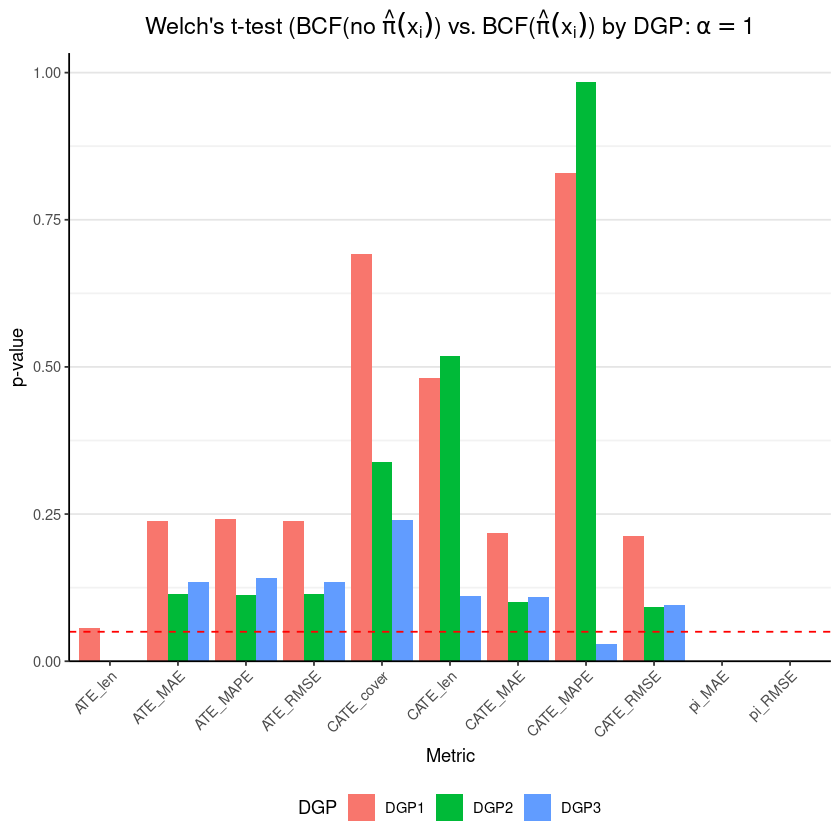

In [15]:

library(readxl)
library(dplyr)
library(ggplot2)
library(latex2exp)

# --- Provided Setup ---
# List of DGPs
dgps <- c("DGP1", "DGP2", "DGP3") # This will be our main loop iterator

fixed_sample_size <- 250 # Constant sample size

# List of models (though we are specifically comparing two)
model_names <- c("BCF(no_pi_hat)", "BCF(pi_hat)", "BCF(pi_oracle)")

# Metrics for line plots (not directly used in this t-test script but good for context)
metrics_for_line_plots <- c("CATE_RMSE", "CATE_MAE", "CATE_MAPE","CATE_cover", "CATE_len",
                             "ATE_RMSE", "ATE_MAE", "ATE_MAPE", "ATE_cover", "ATE_len")

# List of all metrics for t-tests (taken from your code block to be modified)
all_metrics <- c("CATE_RMSE", "CATE_MAE", "CATE_MAPE", "CATE_cover", "CATE_len",
                 "ATE_RMSE", "ATE_MAE", "ATE_MAPE", "ATE_len", "pi_RMSE", "pi_MAE")
# Note: The original prompt had "ATE_cover" in the setup and "ATE_len" in the code block's all_metrics.
# I'm using the one from the code block which includes ATE_len. If you need ATE_cover, adjust this list.

# Filename parts corresponding to the models we are comparing
# filename_parts[1] -> "BCF(no_pi_hat)"
# filename_parts[2] -> "BCF" (which becomes "BCF_fixed_sample_size.xlsx")
filename_parts <- c("BCF(no_pi_hat)", "BCF", "BCF(pi_oracle)")

base_data_dir <- "." # ADJUST THIS PATH (e.g., "/path/to/your/simulation_results")

# Subdirectory name within each DGP folder
dgp_subdir <- "alpha=1" # Assuming this is constant as per your setup description

# --- Modified Code for t-tests by DGP ---

t_test_results_by_dgp <- list()

for (dgp_name in dgps) {
  # Construct base path for the current DGP
  current_dgp_path <- file.path(base_data_dir, dgp_name, dgp_subdir)

  # Construct full file paths
  file_no_pi_hat <- file.path(current_dgp_path, paste0(filename_parts[1], "_N", fixed_sample_size, ".xlsx"))
  file_pi_hat    <- file.path(current_dgp_path, paste0(filename_parts[2], "_N", fixed_sample_size, ".xlsx"))

  # Check if files exist
  if (!file.exists(file_no_pi_hat)) {
    warning(paste("File not found for BCF(no_pi_hat) in", dgp_name, ":", file_no_pi_hat, "- Skipping this DGP."))
    next
  }
  if (!file.exists(file_pi_hat)) {
    warning(paste("File not found for BCF(pi_hat) in", dgp_name, ":", file_pi_hat, "- Skipping this DGP."))
    next
  }

  # Read the Excel files
  df_no_pi_hat <- read_excel(file_no_pi_hat)
  df_pi_hat    <- read_excel(file_pi_hat)

  # Initialize data frame for results for this DGP
  dgp_results_df <- data.frame(metric = all_metrics, dgp = dgp_name) # Store results with metric and DGP name

  for (metric in all_metrics) {
    # Check if metric columns exist in both dataframes
    if (!(metric %in% names(df_no_pi_hat)) || !(metric %in% names(df_pi_hat))) {
      warning(paste("Metric", metric, "not found in one or both files for DGP", dgp_name, "- Skipping this metric for this DGP."))
      dgp_results_df[dgp_results_df$metric == metric, "t_statistic"] <- NA
      dgp_results_df[dgp_results_df$metric == metric, "p_value"]     <- NA
      next
    }
    
    # Perform Welch's t-test (assuming unequal variances by default)
    test_result <- t.test(df_no_pi_hat[[metric]], df_pi_hat[[metric]], var.equal = FALSE)
    
    # Store results
    dgp_results_df[dgp_results_df$metric == metric, "t_statistic"] <- test_result$statistic
    dgp_results_df[dgp_results_df$metric == metric, "p_value"]     <- test_result$p.value
  }
  t_test_results_by_dgp[[dgp_name]] <- dgp_results_df
}

# Combine t-test results for plotting
if (length(t_test_results_by_dgp) > 0) {
  t_test_df_by_dgp <- bind_rows(t_test_results_by_dgp)
  t_test_df_by_dgp$dgp <- factor(t_test_df_by_dgp$dgp, levels = dgps) # Ensure correct order for plotting

  # --- Plotting ---

  # Bar plot for p-values, grouped by DGP
  bar_plot_p_val_by_dgp <- ggplot(t_test_df_by_dgp, aes(x = metric, y = p_value, fill = dgp)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
      title = TeX("Welch's t-test (BCF(no $\\hat{\\pi}(x_i)$) vs. BCF($\\hat{\\pi}(x_i)$) by DGP: $\\alpha=1$"),
      x = "Metric",
      y = "p-value",
      fill = "DGP"
    ) +
    theme_classic() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14),
      axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
      legend.position = "bottom",
      panel.background = element_rect(fill = "white"),
      panel.grid.major.y = element_line(color = "grey90"), # Only major horizontal grid lines
      panel.grid.minor.y = element_line(color = "grey95")  # Only minor horizontal grid lines
    ) +
    geom_hline(yintercept = 0.05, color = "red", linetype = "dashed") +
    scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0, 0.05))) # Set y-axis minimum to 0, slight expansion at top

  # Save the plot
  ggsave(
    filename = paste0("t_test_results_p_value_by_DGP_", dgp_subdir, ".png"),
    plot = bar_plot_p_val_by_dgp,
    width = 12, # Increased width for more metrics
    height = 7,
    units = "in",
    dpi = 300
  )
  print(bar_plot_p_val_by_dgp)

} else {
  print("No t-test results were generated. Check file paths and data.")
}